# Tectonic Model: basic functionality

The TectonicModel class represents the spatio-temporal evolution of plates and plate boundaries. It is designed to provide a consistent objects for encoding this information, as well as provding a number of methods that allow communcation between the UW2 simulation and the TectonicModel. 

The TectonicModel creates a directed graph built on the networkx DiGraph object. Plates are represented by nodes in the graph, and plate boundaries by edges. 

Subduction zones are represented by a single directed edge that goes from the subducting plate to the upper plate. Ridges are represented by egdes that connect the two plate in both directions. 



Once created, the TectonicModel then provides a series of utilities to:

* set initial temperature distribution (plate/slab thermal model)
* initialise and manage embedded faults
* map plate and plate boundary velocities to Underworld2 Stokes Systems


In [11]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import UWsubduction as usub

In [12]:
help(usub.TectonicModel)

Help on class TectonicModel in module UWsubduction._tectonicmodel:

class TectonicModel(networkx.classes.digraph.DiGraph)
 |  The TectonicModel creates a directed graph that represents
 |  the spatio-temporal evolution of plates and plate boundaries.
 |  It is designed to provide a consistent objects for encoding this information,
 |  as well as provding a number of methods that allow communcation
 |  between the UW2 simulation and the TectonicModel.
 |  
 |  Parameters
 |  ----------
 |  
 |  mesh : uw.mesh.FeMesh
 |      The mode mesh
 |  starttime: float
 |      The model start time (usually 0)
 |  endtime: float
 |      The model end time
 |  dt: float
 |      The time increment,
 |      (the temporal reolsution of velocity information)
 |  
 |  Notes
 |  -----
 |  most methods requiring two plates will take a tuple (plate1Id, plate2Id)
 |  the DiGraph has_edge() method can be handed a tuple, if it prececeeded by a *
 |  .has_edge(*(plate1Id, plate2Id)) //or// .has_edge(plate1Id, p

## A simple model

In [14]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [15]:
#initialise TectonicModel, add 3 plates

tm = usub.TectonicModel(mesh, 0, 20, 1)

#adding plates adds nodes to the underlying directed graph
tm.add_plate(1, velocities = 1)
tm.add_plate(2,velocities = -1)
tm.add_plate(3, velocities = 0)

#adding plate boundaries adds edges to the directed graph
tm.add_left_boundary(1)
#Note that the first plate ID supplied here is the subductiong plate
tm.add_subzone(1, 2, 0.25, subInitAge=50.0, upperInitAge=10.0)
tm.add_ridge(2, 3, 0.5)
tm.add_right_boundary(3, 30.)

In [16]:
tm.add_subzone?

In [5]:
tm.is_subduction_boundary((1,2))

True

## The plate ID and age functions


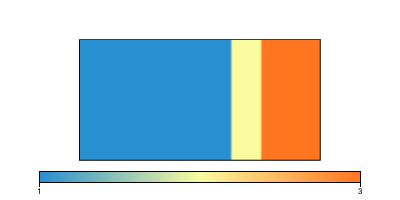

In [6]:

pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, pIdFn ))
fig.show()


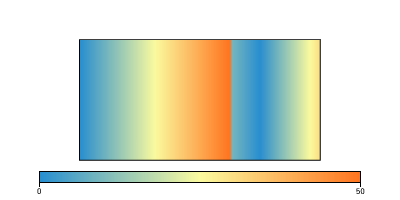

In [7]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, fnAge_map ))
fig.show()

## Mask fuctions

These are binary functions that basically allow you to identify the horizontal position of different plate boundaries in the model. This is useful in case you want to apply some kind of special conditions here near or away from the plate boundary. 




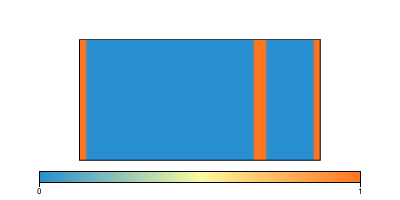

In [8]:
boundMaskFn = tm.plate_boundary_mask_fn(0.1)
RboundMaskFn = tm.ridge_mask_fn(0.05)
SboundMaskFn = tm.subduction_mask_fn(0.1)

#We can 'add' these mask functions like so
boundMaskFn = tm.combine_mask_fn(RboundMaskFn, SboundMaskFn )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, RboundMaskFn ))
fig.show()


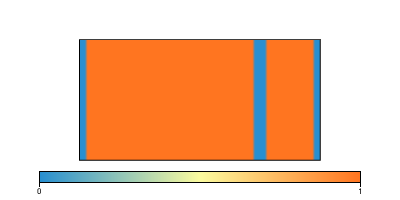

In [9]:
#It is also useful to be able invert mask fanctions

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, tm.t2f(RboundMaskFn) ))
fig.show()


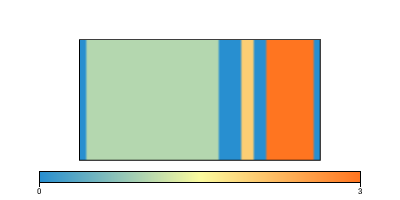

In [10]:
#We can also have  masked Plate Function 

maskedPlateIdFn = tm.plate_id_fn(maskFn=boundMaskFn)
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tm.mesh, maskedPlateIdFn , valueRange = [0, 3] ))
fig.show()

## General queries

In [20]:
#We can traverse the undirect graph and use these functions to query the underlying directed data structue
for e in tm.undirected.edges():
    print(e)
    print(tm.is_ridge(e), tm.is_subduction_boundary(e))

(1, 1)
True False
(1, 2)
False True
(2, 3)
True False
(3, 3)
True False
